# Imports

In [3]:
import networkx as nx
import numpy as np
import math
from matplotlib import lines
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
import random
import shapefile
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import subprocess
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Functions

## Data Loading

In [4]:
## This function is to load a .csv file into a pandas dataframe of desired format
def load_dataset(dataset_path, train=False, bias=1e-2, log_transform=False):
    raw_dataset = pd.read_csv(dataset_path)

    ## If the data is for testing
    if (train == False):
        meta_data = raw_dataset.iloc[:, :3] ## LATITUDE, LONGITUDE, VALID_POINTS
        date_data = raw_dataset.iloc[:, 3:] ## Rainfall data columns

        date_data.columns = pd.to_datetime(date_data.columns)

        mask = date_data.columns.map(
            lambda d: (d.month > 5 and d.month < 10)
        )

        dataset_not_transformed = date_data.loc[:, mask]
        dataset_not_transformed.columns = dataset_not_transformed.columns.strftime('%Y-%m-%d')

        ## To add LOC_ID column
        loc_id = pd.Series([i for i in range(meta_data.shape[0])], name='LOC_ID')
        meta_data = pd.concat([loc_id.reset_index(drop=True), meta_data.reset_index(drop=True)], axis=1)
        dataset_not_transformed = pd.concat([meta_data, dataset_not_transformed], axis=1)

    ## If the data is to be bias + log_transformed
    if (log_transform == True):
        bias = 1e-2
        meta_columns = ['LOC_ID', 'LATITUDE', 'LONGITUDE', 'VALID_POINTS']
        dataset = dataset_not_transformed.copy()
        dataset.loc[:, ~dataset.columns.isin(meta_columns)] = np.log1p(dataset_not_transformed.loc[:, ~dataset.columns.isin(meta_columns)] + bias)
    else:
        dataset = dataset_not_transformed

    return dataset

## Graph Generation

### Year-wise Dictionary

In [6]:
## This function is to generate year-wise daily rainfall for every location in a dictionary format
def make_year_wise_dict(dataframe, years=list(range(2015, 2023))):
    year_wise_dict = dict()

    year_columns = {
        year: [col for col in dataframe.columns if str(year) in str(col)]
        for year in years
    }
    
    col_positions = {col: i for i, col in enumerate(dataframe.columns)}

    ## itertuples is faster than iterrows, but it cannot alter the accessed data
    for row in dataframe.itertuples(index=False):
        loc_id = row.LOC_ID

        year_wise_dict[loc_id] = {}

        for year in years:
            cols = year_columns[year]

            rainfall_vector = [row[col_positions[col]] for col in cols]
            year_wise_dict[loc_id][year] = np.array(rainfall_vector)

    return year_wise_dict

### Cosine Similarity Dictionary

In [7]:
## This function to compute cosine similarity matrix for every location
def make_cos_sim_dict(year_wise_dict, ids, years=list(range(2015, 2023))):
    cos_sim_dict = dict()

    for id in ids:

        vectors = [year_wise_dict[id][year] for year in years]
        tensor_data = torch.tensor(vectors, dtype=torch.float32)

        norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
        sim_matrix = torch.mm(norm_data, norm_data.T)

        cos_sim_dict[id] = sim_matrix

    return cos_sim_dict

### Mean Node Generation

In [8]:
## This function is to make a mean node for all locations
def make_mean_node(year_wise_dict, ids, years=list(range(2015, 2023))):
    
    for id in ids:
        sum = np.zeros(np.shape(year_wise_dict[id][2022]))

        for year in years:
            sum += year_wise_dict[id][year]

        year_wise_dict[id]['MEAN'] = sum / len(years)

    return year_wise_dict

### Making Graphs

In [ ]:
## This function is to make the actual graphs
def make_graphs(year_wise_dict, cos_sim_dict, ids, years=list(range(2015, 2023)), threshold=0.38736847043037415):
    graphs = dict()

    for id in ids:

        edge_list = []

        for i in range(len(years)):
            
            ## 0 is considered as the average node, and each year node has the index (year - 2014)
            edge_list.append([[i + 1], [0]])

            for j in range(len(years)):
                if i < j:
                    score = cos_sim_dict[id][i][j]

                    if score > threshold:
                        ## Each year node has the index (year - 2014)
                        edge_list.append([[i + 1], [j + 1]])

        edge_list = np.hstack(edge_list)
        edge_list = torch.tensor(edge_list, dtype=torch.long)

        node_features = [year_wise_dict[id]['MEAN']]

        for year in years:
            node_features.append(year_wise_dict[id][year])

        node_features = np.vstack(node_features)
        node_features = torch.tensor(node_features, dtype=torch.float)

        label = torch.tensor([0.5])

        graph = Data(x=node_features, edge_index=edge_list, y=label)

        graphs[id] = graph

    return graphs

### Final Function

In [10]:
## This function is to generate graphs given a dataframe
def generate_graphs(dataframe, train=False):

    ## If the graphs are for testing the model
    if (train == False):
        ## The unique IDs for each location
        loc_ids = dataframe['LOC_ID'].values

        ## The various years in the dataset
        years = pd.to_datetime(dataframe.columns[4:]).year
        years = sorted(years.unique())

        ## Obtain year-wise daily rainfall for every location in a dictionary format
        year_wise_dict = make_year_wise_dict(
            dataframe=dataframe,
            years=years
        )

        ## Compute cosine similarity matrix for every location
        cos_sim_dict = make_cos_sim_dict(
            year_wise_dict=year_wise_dict,
            ids=loc_ids,
            years=years
        )

        ## To make a mean node for all locations
        year_wise_dict = make_mean_node(
            year_wise_dict=year_wise_dict,
            ids=loc_ids,
            years=years
        )

        ## To make the actual graphs
        graphs = make_graphs(
            year_wise_dict=year_wise_dict,
            cos_sim_dict=cos_sim_dict,
            ids=loc_ids,
            years=years,
            threshold=0.38736847043037415
        )

        return graphs

## Model

### Predictions

In [11]:
## This function is to make predictions
def make_predictions(model, graphs):
    model.eval()

    y_pred = dict()

    for id, graph in graphs.items():

        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        y_pred[id] = prediction

    return y_pred

## Visualizations

### Graphs

In [12]:
## This function is to visualize graphs
def display_graph(graphs, num_graphs=1):
    for i in range(num_graphs):
        rand_id = np.random.choice(list(graphs.keys()))
        print(f"The randomly selected TRGCODE is {rand_id}")

        G = to_networkx(graphs[rand_id], to_undirected=True)

        fig, ax = plt.subplots(figsize=(6, 4))
        nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
        plt.show()

### Geographical Map

In [13]:
## This function is to visualize the stable and unstable regions in a geographical map
def display_geo_map(dataframe, y_pred, shapefile_path, ids, transform=False, figsize=(10, 10)):
    # Initialize shapefile reader
    sf = shapefile.Reader(shapefile_path)

    if (transform == True):
        # UTM Zone 43N → WGS84 lat/lon
        transformer = lambda x, y: Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True).transform(x, y)
    else:
        ## Identity Transformation
        transformer = lambda x, y: (x, y)

    fig, ax = plt.subplots(figsize=figsize)

    for shape in sf.shapes():
        points = shape.points
        parts = list(shape.parts) + [len(points)]
        
        for i in range(len(parts) - 1):
            part_points = points[parts[i]:parts[i + 1]]
            x_proj, y_proj = zip(*part_points)
            lon, lat = transformer(x_proj, y_proj)
            ax.plot(lon, lat, color='black')

    for id in ids:

        if y_pred[id] == 1:
            color = 'red'
            alpha = 0.7
        else:
            color = 'green'
            alpha = 0.5

        plt.scatter(
            dataframe.loc[dataframe['LOC_ID'] == id, 'LONGITUDE'],
            dataframe.loc[dataframe['LOC_ID'] == id, 'LATITUDE'],
            color=color,
            alpha=alpha
        )

    legend_elements = [
        lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
        lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
    ]

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title("Geographical Map Visualization")
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.show()

# Loading the Model

## Defining the Model Architecture

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(3707)
        self.conv1 = GCNConv(122, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) ## Same size to refine node embeddings
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        ## STEP 1: To obtain node embeddings
        x = self.conv1(x, edge_index) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)

        ## STEP 2: Readout layer
        x = global_max_pool(x, batch) ## Computes batch wise mean of the graphs that have been batched. Returns one feature vector per batch

        ## STEP 3: Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) ## Dropout is regularization to prevent overfitting
        x = self.lin(x)

        return x

## Loading the Weights

In [15]:
model = GCN(hidden_channels=32)
# model.load_state_dict(torch.load('model_log_bias.pth'))
model.load_state_dict(torch.load('model_vanilla.pth'))

/tmp/ipykernel_675285/3528221429.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_vanilla.pth'))


<All keys matched successfully>

# Karnataka

In [16]:
karnataka_dataset = load_dataset(
    dataset_path='karnataka_grid_timeseries.csv',
    train=False,
    bias=1e-2,
    log_transform=False
)

In [17]:
karnataka_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,74.05,11.55,70090,1.280954,0.079308,3.967222,32.774185,0.827167,6.825593,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.592231
1,1,74.05,11.65,70090,1.145191,0.445717,6.743265,30.673952,0.908627,3.723992,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.395695
2,2,74.05,11.75,70090,0.591019,0.763167,9.621930,29.946466,1.280922,1.230831,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.422275
3,3,74.05,11.85,70090,0.000000,1.461665,7.120384,32.693462,2.625886,1.861328,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.499051
4,4,74.05,11.95,70090,0.000000,0.932015,5.177581,34.063496,4.559991,2.174394,...,0.000000,0.000000,0.014793,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.025963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,3332,78.65,18.15,70090,0.873916,8.688861,0.000000,3.845152,0.150311,1.967779,...,10.950179,2.793023,0.000000,0.0,0.0,2.216781,0.0,6.281692,4.701965,0.000000
3333,3333,78.65,18.25,70090,1.208413,9.457102,0.000000,3.674678,0.155699,1.433062,...,11.577258,2.978141,0.000000,0.0,0.0,2.114422,0.0,4.689294,2.724058,0.000000
3334,3334,78.65,18.35,70090,1.521100,8.647934,0.000000,3.218774,0.136055,1.334297,...,10.190564,2.480615,0.000000,0.0,0.0,3.263117,0.0,3.454654,1.452241,0.000000
3335,3335,78.65,18.45,70090,2.050546,6.312897,0.000000,2.340701,0.108734,0.920564,...,6.973896,1.481436,0.000000,0.0,0.0,7.072689,0.0,2.507486,0.741378,0.000000


In [134]:
karnataka_graphs = generate_graphs(
    dataframe=karnataka_dataset,
    train=False
)

In [135]:
karnataka_y_pred = make_predictions(
    model=model,
    graphs=karnataka_graphs
)

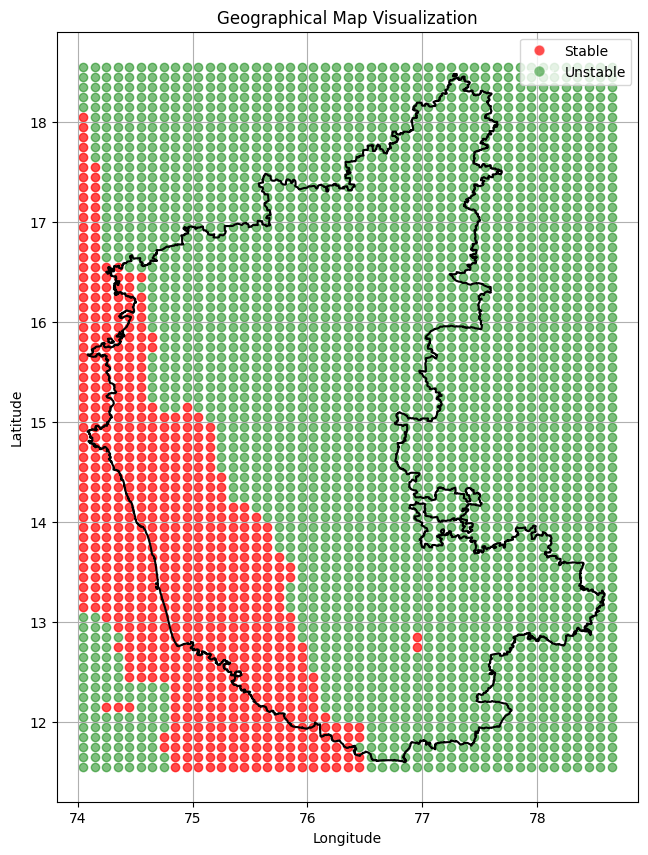

In [136]:
display_geo_map(
    dataframe=karnataka_dataset,
    y_pred=karnataka_y_pred,
    shapefile_path='Karnataka/State.shp',
    ids=karnataka_dataset['LOC_ID'].values,
    transform=True,
    figsize=(7.5, 10)
)

# Maharashtra

In [137]:
mh_dataset = load_dataset(
    dataset_path='maharashtra_grid_timeseries.csv',
    train=False,
    bias=1e-2,
    log_transform=False
)

In [138]:
mh_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,71.95,14.05,70090,0.0,0.000000,0.0,0.000000,4.326894,31.442840,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,71.95,14.15,70090,0.0,0.000000,0.0,0.064278,14.200664,33.460274,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,71.95,14.25,70090,0.0,0.000000,0.0,0.064827,14.303348,28.642290,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,71.95,14.35,70090,0.0,0.000000,0.0,1.349914,11.723515,28.708788,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,71.95,14.45,70090,0.0,0.000000,0.0,5.211508,11.612844,34.883457,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,9186,81.95,22.65,70090,0.0,2.593090,0.0,0.000000,4.202532,4.015653,...,13.608622,2.417222,16.516293,1.540201,0.0,0.000000,0.000000,0.626786,3.425099,0.490838
9187,9187,81.95,22.75,70090,0.0,1.736164,0.0,0.000000,3.784898,3.892778,...,10.837712,3.196050,16.880562,2.037866,0.0,0.000000,0.000000,0.335622,2.131816,0.587263
9188,9188,81.95,22.85,70090,0.0,1.152034,0.0,0.000000,3.391212,3.688646,...,8.506171,3.598018,16.147757,2.241968,0.0,0.000000,0.000000,0.888190,0.974874,0.583566
9189,9189,81.95,22.95,70090,0.0,0.698547,0.0,0.000000,2.660206,3.330278,...,7.885351,4.207828,14.169415,2.042953,0.0,1.007939,0.734564,1.585108,0.000000,0.445981


In [139]:
mh_graphs = generate_graphs(
    dataframe=mh_dataset,
    train=False
)

In [140]:
mh_y_pred = make_predictions(
    model=model,
    graphs=mh_graphs
)

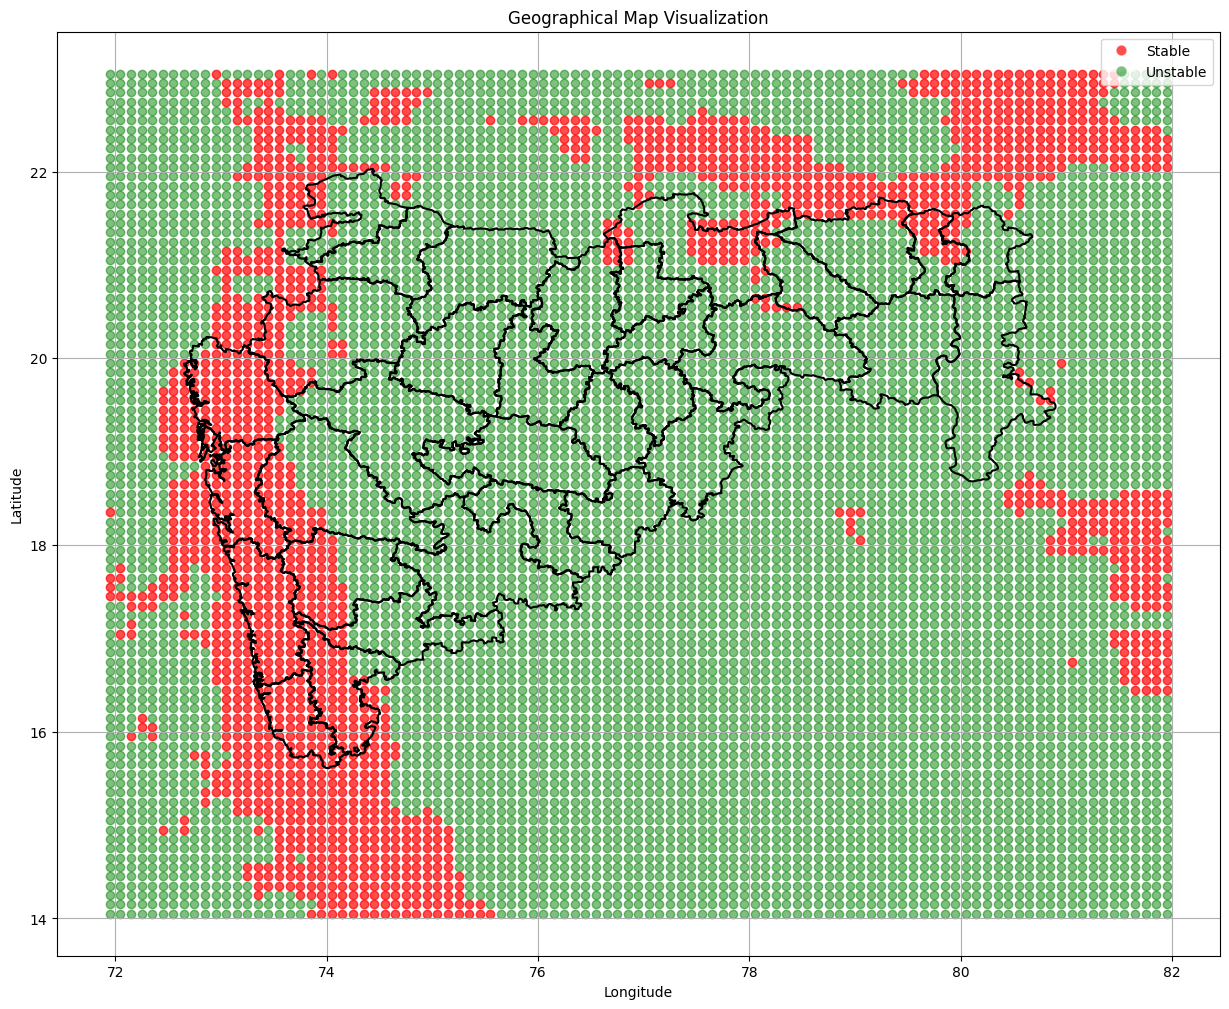

In [141]:
display_geo_map(
    dataframe=mh_dataset,
    y_pred=mh_y_pred,
    shapefile_path='new_maha_district.shp',
    ids=mh_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 12)
)

The randomly selected TRGCODE is 2553


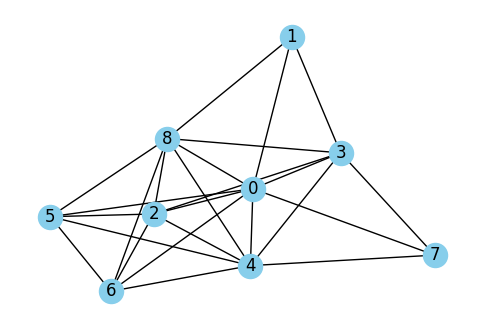

The randomly selected TRGCODE is 2267


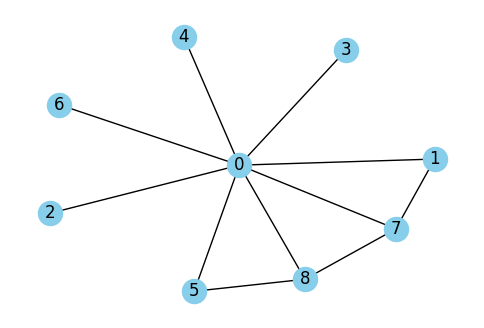

The randomly selected TRGCODE is 5285


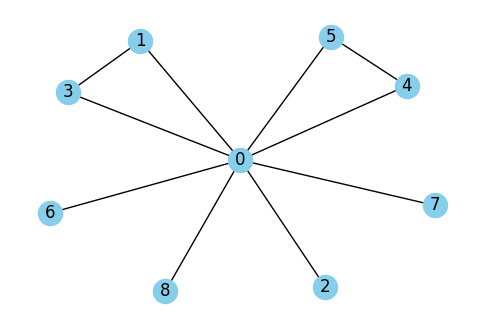

The randomly selected TRGCODE is 6087


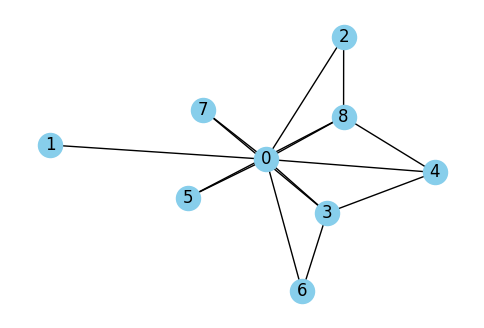

The randomly selected TRGCODE is 4279


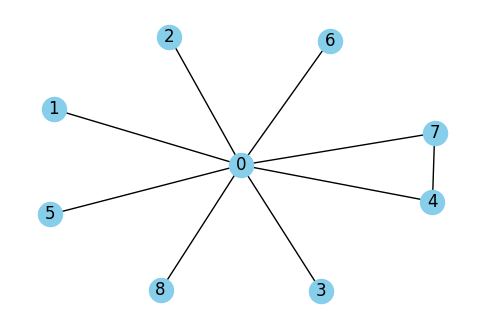

In [157]:
display_graph(mh_graphs, 5)

In [162]:
mh_y_pred[2267]

0

# Central India

In [142]:
central_ind_dataset = load_dataset(
    dataset_path='central_india_grid_timeseries.csv',
    train=False,
    bias=1e-2,
    log_transform=False
)

In [143]:
central_ind_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,74.95,15.05,70090,0.000000,11.485754,0.000000,10.137968,0.000000,3.714085,...,0.0,0.0,2.876844,0.479882,0.000000,2.530887,0.000000,0.0,9.066235,25.281624
1,1,74.95,15.15,70090,0.000000,11.994020,0.000000,12.116782,0.000000,5.889081,...,0.0,0.0,2.482644,0.419246,0.000000,3.793489,0.000000,0.0,11.359647,27.087297
2,2,74.95,15.25,70090,0.000000,11.822428,0.000000,13.197187,0.000000,6.722695,...,0.0,0.0,2.141675,0.380451,0.000000,4.486527,0.000000,0.0,12.518871,26.082720
3,3,74.95,15.35,70090,0.000000,10.491586,0.000000,13.393895,0.000000,8.394069,...,0.0,0.0,1.394328,0.333149,0.000000,4.886819,0.000000,0.0,13.341432,23.426773
4,4,74.95,15.45,70090,0.256735,8.000398,0.000000,13.089703,0.000000,10.433373,...,0.0,0.0,0.000000,0.000000,0.000000,5.620771,0.000000,0.0,14.733215,20.058290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,10196,84.95,24.65,70090,0.000000,0.000000,3.145125,0.930856,0.339518,0.000000,...,0.0,0.0,0.000000,4.122879,0.830155,4.747128,1.872283,0.0,18.634129,2.714485
10197,10197,84.95,24.75,70090,0.103753,0.000000,2.639899,1.139674,0.105412,0.000000,...,0.0,0.0,0.000000,3.697504,0.819181,3.645599,2.394115,0.0,18.913820,1.291317
10198,10198,84.95,24.85,70090,0.351128,0.000000,2.206800,1.280096,0.107782,0.000000,...,0.0,0.0,0.000000,2.892420,0.857805,3.925954,2.430019,0.0,17.603289,0.769847
10199,10199,84.95,24.95,70090,0.801275,0.000000,1.587789,1.486625,1.871137,0.458292,...,0.0,0.0,0.000000,2.833635,1.033310,4.658983,1.866957,0.0,14.221844,0.424465


In [146]:
central_ind_graphs = generate_graphs(
    dataframe=central_ind_dataset,
    train=False
)

In [147]:
central_ind_y_pred = make_predictions(
    model=model,
    graphs=central_ind_graphs
)

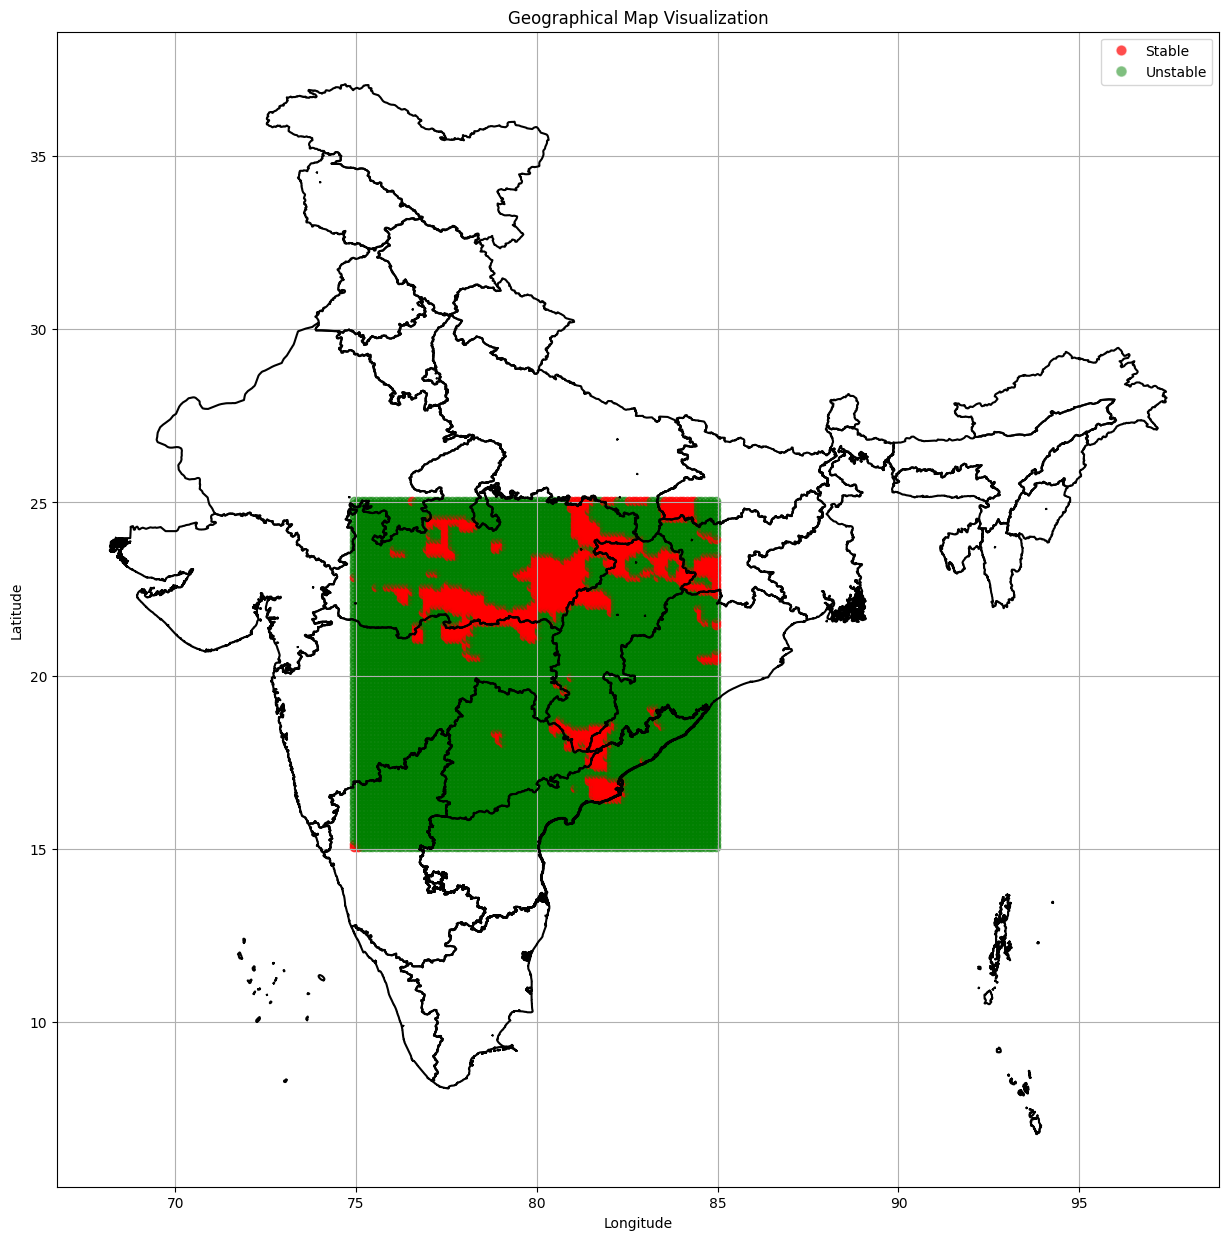

In [149]:
display_geo_map(
    dataframe=central_ind_dataset,
    y_pred=central_ind_y_pred,
    shapefile_path='India_State/india_updated_state_boundary.shp',
    ids=central_ind_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 15)
)

# North-East India

In [150]:
ne_ind_dataset = load_dataset(
    dataset_path='ne_india_grid_timeseries.csv',
    train=False,
    bias=1e-2,
    log_transform=False
)

In [151]:
ne_ind_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,87.95,22.05,70090,0.0,0.0,0.0,0.0,0.209488,0.0,...,3.445832,0.462167,0.000000,0.000000,0.000000,0.000000,9.217576,11.867368,3.231712,0.390482
1,1,87.95,22.15,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,3.283824,0.390107,0.000000,0.000000,0.000000,0.000000,10.983496,14.960486,3.601541,0.527324
2,2,87.95,22.25,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,3.061379,0.327972,0.000000,0.000000,0.000000,0.118146,11.232228,16.499823,2.862582,0.558649
3,3,87.95,22.35,70090,0.0,0.0,0.0,0.0,0.113166,0.0,...,3.598255,0.333714,0.000000,0.000000,0.000000,0.752311,10.430651,17.359642,2.394127,0.475612
4,4,87.95,22.45,70090,0.0,0.0,0.0,0.0,0.219381,0.0,...,4.171506,0.420676,0.000000,0.000000,0.000000,1.893519,8.827864,16.572410,0.507374,0.217358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,8176,97.95,29.65,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.441126,4.938614,1.440112,6.273499,0.852056,0.453990,6.233571,0.000000,0.000000,0.000000
8177,8177,97.95,29.75,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.533195,4.436704,2.440185,6.438449,0.895569,0.720881,6.577987,0.000000,0.000000,0.000000
8178,8178,97.95,29.85,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.660598,5.056315,2.818824,6.538489,1.023058,0.661583,6.312856,0.605272,0.000000,0.000000
8179,8179,97.95,29.95,70090,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.798540,5.879838,3.017806,6.322617,0.883932,0.542335,6.921481,1.047228,0.000000,0.000000


In [152]:
ne_ind_graphs = generate_graphs(
    dataframe=ne_ind_dataset,
    train=False
)

In [153]:
ne_ind_y_pred = make_predictions(
    model=model,
    graphs=ne_ind_graphs
)

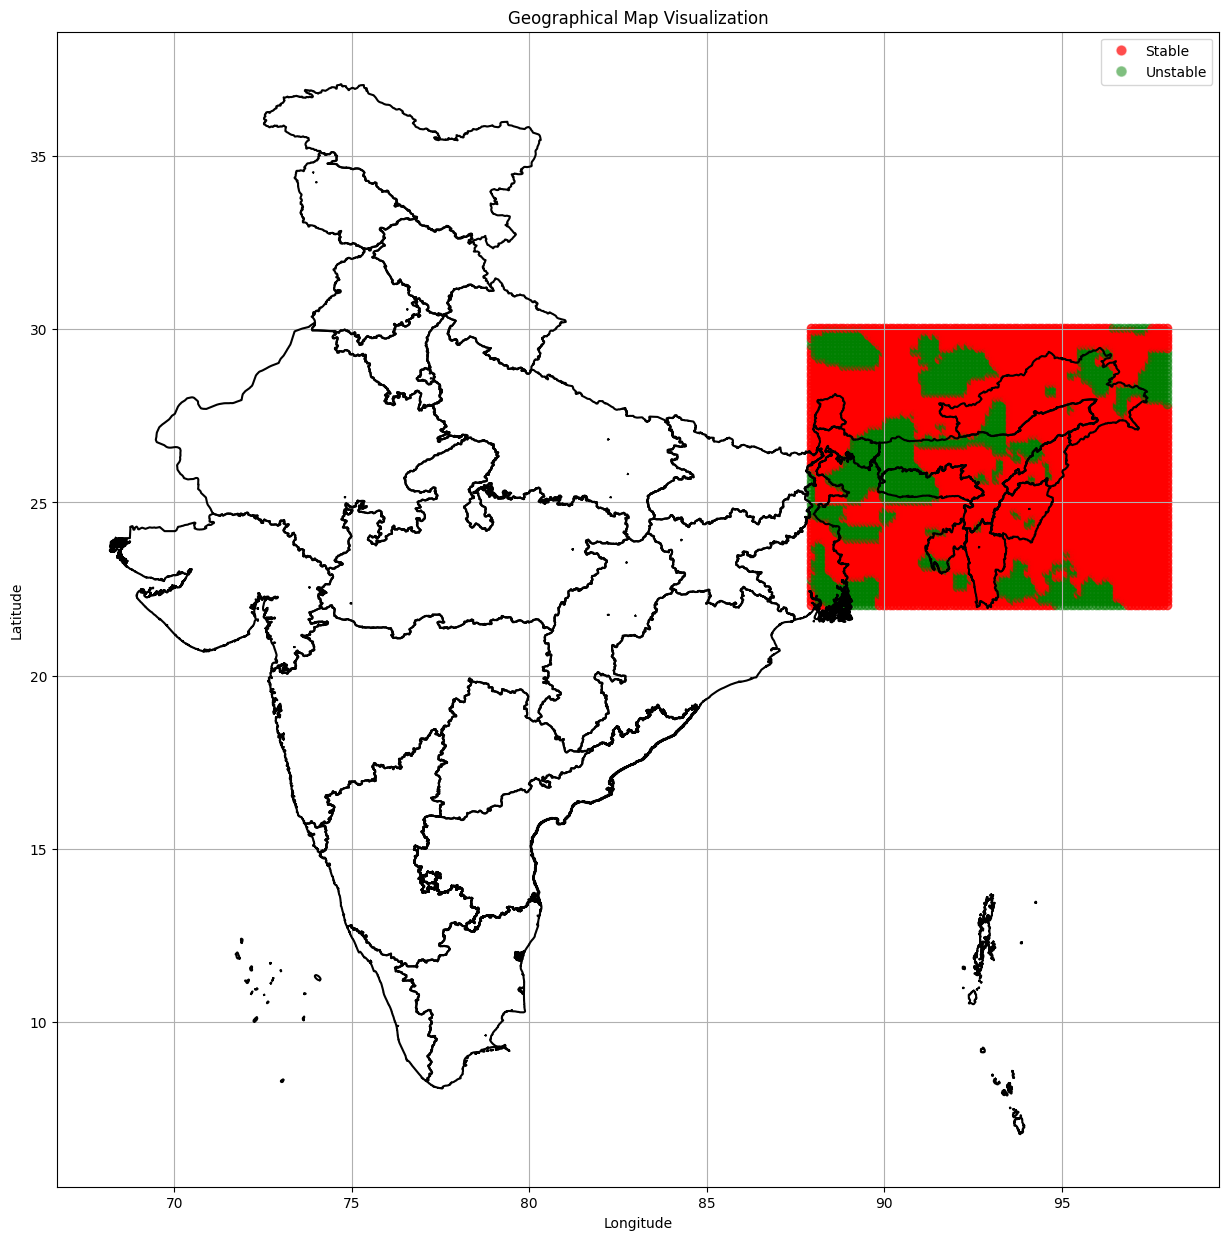

In [154]:
display_geo_map(
    dataframe=ne_ind_dataset,
    y_pred=ne_ind_y_pred,
    shapefile_path='India_State/india_updated_state_boundary.shp',
    ids=ne_ind_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 15)
)